In [1]:
!nvidia-smi

Wed Jun 16 03:39:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
tf.__version__

'2.5.0'

In [3]:
!pip install split-folders

In [4]:
!unzip "/content/drive/MyDrive/DATASETS/Malaria Dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_116.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_221.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_222.png  
  inflating: cell_i

In [5]:
!rm -rf "/content/cell_images/cell_images"

In [6]:
import splitfolders
splitfolders.ratio('/content/cell_images', output='output', seed=1337, ratio=(.6, 0.3,0.1))

Copying files: 27560 files [00:03, 6982.75 files/s]


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
import os
import glob
train_data = glob.glob('/content/output/train/**/*.png')
val_data = glob.glob('/content/output/test/**/*.png')
test_data = glob.glob('/content/output/val/**/*.png')

print(f"Training Set has: {len(train_data)} images")
print(f"Testing Set has: {len(test_data)} images")
print(f"Validation Set has: {len(val_data)} images")

Training Set has: 16534 images
Testing Set has: 8268 images
Validation Set has: 2756 images


In [22]:
DIR = "/content/output"
sets = ["train", "test", "val"]
all_malaria = []
all_normal = []

for cat in sets:
    path = os.path.join(DIR, cat)
    norm = glob.glob(os.path.join(path, "Uninfected/*.png"))
    malaria = glob.glob(os.path.join(path, "Parasitized/*.png"))
    all_normal.extend(norm)
    all_malaria.extend(malaria)

print(f"Total Malaria Images: {len(all_malaria)}")
print(f"Total Normal Images: {len(all_normal)}")

Total Malaria Images: 13779
Total Normal Images: 13779


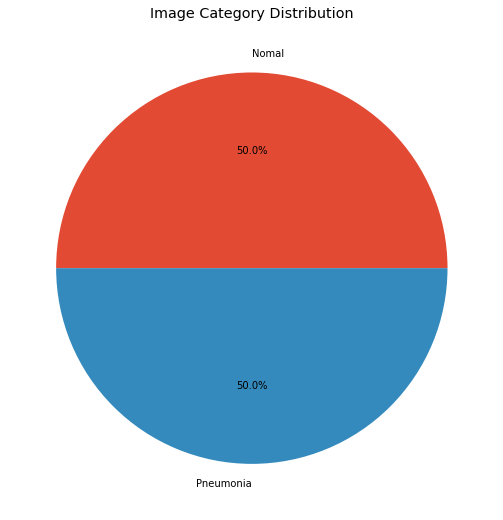

In [24]:
labels = ['Nomal', 'Pneumonia']
targets = [len(all_normal), len(all_malaria)]

plt.style.use("ggplot")
plt.figure(figsize=(16, 9))
plt.pie(x=targets, labels=labels, autopct="%1.1f%%")
plt.title("Image Category Distribution")
plt.show()

In [47]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [48]:
# re-size all the images to this
IMAGE_SIZE = [299, 299]  #Inception input size

train_path = '/content/output/train'
valid_path = '/content/output/val'

In [49]:
original_model = InceptionV3(weights='imagenet')

96116736/96112376 [==============================] - 1s 0us/step


In [50]:
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

87916544/87910968 [==============================] - 1s 0us/step


In [51]:
# don't train existing weights 
for layer in inception.layers:
    layer.trainable = False

In [13]:
folders = glob('/content/output/train/*')

In [52]:
x = Flatten()(inception.output)

In [53]:
prediction = Dense(len(folders), activation='softmax')(x)
#len(folders) is 2 since we have 2 classes

# create a model object
model = Model(inputs=inception.input, outputs=prediction)

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [54]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('/content/output/train',
                                                 target_size = (299, 299),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 16534 images belonging to 2 classes.


In [55]:
test_set = test_datagen.flow_from_directory('/content/output/val',
                                            target_size = (299, 299),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 8268 images belonging to 2 classes.


In [39]:
import glob
train_P=glob.glob('/content/output/train/Parasitized/*.png')
print("The number of infected training images are",len(train_P))
train_N=glob.glob('/content/output/train/Uninfected/*.png')
print("The number of normal training images are",len(train_N))


The number of infected training images are 8267
The number of normal training images are 8267


In [40]:
import tensorflow
from IPython.display import clear_output
class PlotLearning(tensorflow.keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

In [57]:
# tell the model what cost and optimization method to use
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

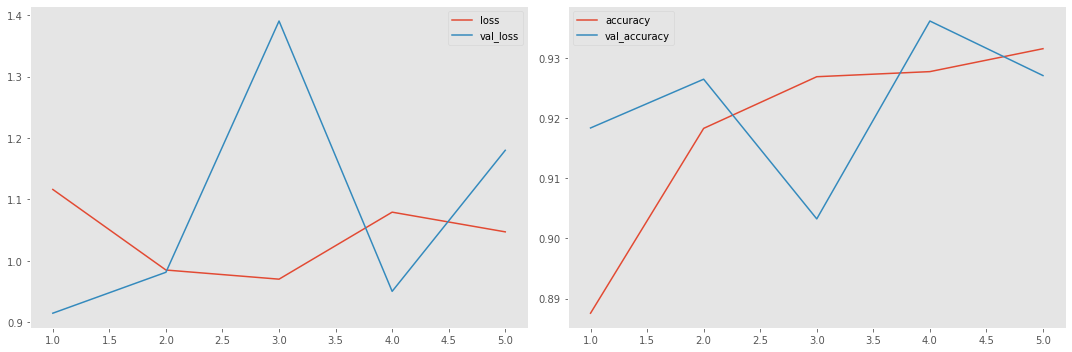

In [58]:
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set),
  callbacks=[PlotLearning()]
)

In [59]:
model.evaluate(test_set)

259/259 [==============================] - 32s 122ms/step - loss: 1.1800 - accuracy: 0.9271


[1.1799944639205933, 0.9270682334899902]

In [60]:
model.save("MalariaAcc92-71E5B32.h5")